# Sentiment Analysis with Pyspark

In [1]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

First step in any Apache programming is to create a SparkContext. SparkContext is needed when we want to execute operations in a cluster. SparkContext tells Spark how and where to access a cluster. It is first step to connect with Apache Cluster. 

In [2]:
try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

C:\apps\opt\spark-3.3.1-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Just created a SparkContext


In [3]:
sc.master

'local[4]'

In [4]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('clean_tweet.csv')

In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
#showing the first 5 rows of our data
df.show(5)

+---+--------------------+------+
|_c0|                text|target|
+---+--------------------+------+
|  0|awww that s a bum...|   0.0|
|  1|is upset that he ...|   0.0|
|  2|i dived many time...|   0.0|
|  3|my whole body fee...|   0.0|
|  4|no it s not behav...|   0.0|
+---+--------------------+------+
only showing top 5 rows



In [7]:
df = df.dropna()#removing the missed values

In [8]:
#spiliting my data into 3 parts as train test and validation
(train_set, val_set, test_set) = df.randomSplit([0.8, 0.1, 0.1], seed = 2000)

## HashingTF + IDF + Logistic Regression

In [9]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator #Evaluates the output with optional parameters

In [10]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words") #converts the input string to lowercase and then splits it by white spaces
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf') #Maps a sequence of terms to their term frequencies
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label") #A label indexer that maps a string column of labels to an ML column of label indices
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx]) #assemble several steps that can be cross-validated together while setting different parameters

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|_c0|                text|target|               words|                  tf|            features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|  0|awww that s a bum...|   0.0|[awww, that, s, a...|(65536,[18354,216...|(65536,[18354,216...|  0.0|
|  1|is upset that he ...|   0.0|[is, upset, that,...|(65536,[1981,3085...|(65536,[1981,3085...|  0.0|
|  2|i dived many time...|   0.0|[i, dived, many, ...|(65536,[2548,2888...|(65536,[2548,2888...|  0.0|
|  3|my whole body fee...|   0.0|[my, whole, body,...|(65536,[1880,9243...|(65536,[1880,9243...|  0.0|
|  4|no it s not behav...|   0.0|[no, it, s, not, ...|(65536,[1968,8538...|(65536,[1968,8538...|  0.0|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.8673222997847624

And for binary classification, Spark doesn't support accuracy as a metric. But I can still calculate accuracy by counting the number of predictions matching the label and dividing it by the total entries.

In [13]:
evaluator.getMetricName()

'areaUnderROC'

In [14]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.7963058171467265

Now it looks more plausible, actually the accuracy is slightly lower than what I have seen from SKLearn's result.

## CountVectorizer + IDF + Logistic Regression

There's another way to get term frequecy for IDF (Inverse Document Freqeuncy) calculation. It is CountVectorizer in SparkML. Apart from the reversibility of the features (vocabularies), there is an important difference in how each of them filters top features. In case of HashingTF it is dimensionality reduction with possible collisions. CountVectorizer discards infrequent tokens.

In [15]:
%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')#occurences of token
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print ("Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.8033
ROC-AUC: 0.8739
Wall time: 1min 19s


It looks like using CountVectorizer has improved the performance a little bit.

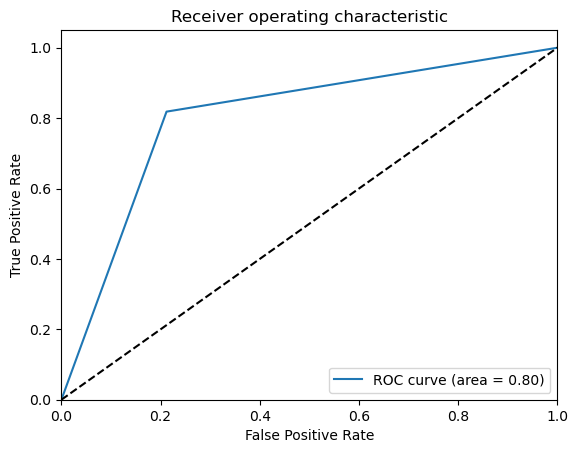

In [16]:
#ROC-AUC curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Get the predictions and labels
predictions = predictions.select('prediction', 'label').toPandas()
fpr, tpr, _ = roc_curve(predictions['label'], predictions['prediction'])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()